In [1]:
import pandas as pd
import numpy as np
import pyretro.boxball_loader as bbl

In [2]:
DATA_DIR='../../data'

In [3]:
years = bbl.Seasons(2015, 2022)
stats = ['pa', 'runs_scored', 'hr', 's', 'd', 't', 'k', 'bb', 'ab']

agg_cols = stats + ['g', 'length_in_outs']

In [4]:
def get_gamelogs(years):
    # Narrow to years and regular-season games
    df = bbl.load_gamelogs(bbl.GameType.RS, years)

    # Add plate appearances and singles as stats we care about
    for HA in ['home', 'visitor']:
        df[f'{HA}_pa'] = df[f'{HA}_ab'] + df[f'{HA}_bb'] + df[f'{HA}_hbp'] + df[f'{HA}_sh'] + df[f'{HA}_sf']
        df[f'{HA}_s'] = df[f'{HA}_h'] - df[f'{HA}_d'] - df[f'{HA}_t'] - df[f'{HA}_hr']

    # These are the columns we care about
    standard_cols = ['yr', 'game_type', 'home_team', 'visiting_team', 'park_id', 'length_in_outs']
    stat_cols = [f'{HA}_{stat}' for HA in ['home', 'visitor'] for stat in stats]
    cols = standard_cols+stat_cols
    
    gl = df[cols].copy()
    gl['g'] = 1

    # For the stats, compute both teams' totals in each game
    for stat in stats:
        gl[stat] = gl['home_'+stat]+gl['visitor_'+stat]
    
    # Fix a bug in the Retrosheet data for the 2020 Rangers
    gl.loc[(gl['home_team']=='TEX')&(gl['yr']==2020), 'park_id'] = 'ARL03'
    
    return gl

In [5]:
gl = get_gamelogs(years)
gl

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
18637,2015,RS,CHN,SLN,CHI11,54.0,34.0,0,0.0,2.0,...,1,74.0,3,0.0,9.0,6.0,0.0,23.0,6.0,68.0
18647,2015,RS,LAN,SDN,LOS03,51.0,39.0,6,2.0,2.0,...,1,74.0,9,2.0,5.0,8.0,1.0,22.0,7.0,64.0
18641,2015,RS,NYA,TOR,NYC21,54.0,33.0,1,1.0,2.0,...,1,72.0,7,3.0,6.0,0.0,0.0,17.0,8.0,62.0
18642,2015,RS,OAK,TEX,OAK01,51.0,41.0,8,2.0,5.0,...,1,71.0,8,2.0,6.0,3.0,1.0,14.0,5.0,65.0
18643,2015,RS,SEA,ANA,SEA03,51.0,33.0,4,1.0,5.0,...,1,65.0,5,2.0,8.0,3.0,1.0,15.0,3.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40088,2022,RS,NYN,WAS,NYC20,51.0,36.0,9,2.0,8.0,...,1,71.0,11,3.0,13.0,3.0,0.0,16.0,3.0,67.0
40087,2022,RS,MIL,ARI,MIL06,54.0,35.0,2,1.0,4.0,...,1,71.0,6,3.0,11.0,4.0,0.0,22.0,3.0,68.0
40086,2022,RS,MIA,ATL,MIA02,51.0,41.0,12,2.0,9.0,...,1,87.0,21,4.0,15.0,7.0,2.0,16.0,9.0,76.0
40084,2022,RS,CIN,CHN,CIN09,54.0,40.0,2,0.0,5.0,...,1,88.0,17,3.0,12.0,4.0,1.0,20.0,12.0,74.0


In [6]:
# Find each teams-season's primary park (the park in which they played the most home games)
def find_primary_parks(gl):
    hgbp = gl.groupby(['yr', 'home_team', 'park_id'])['g'].sum() # home games per park
    primary_parks = hgbp[hgbp.groupby(['yr', 'home_team']).transform(max) == hgbp].reset_index(level=-1)['park_id']
    return primary_parks

primary_parks = find_primary_parks(gl)
primary_parks

yr    home_team
2015  ANA          ANA01
      ARI          PHO01
      ATL          ATL02
      BAL          BAL12
      BOS          BOS07
                   ...  
2022  SLN          STL10
      TBA          STP01
      TEX          ARL03
      TOR          TOR02
      WAS          WAS11
Name: park_id, Length: 240, dtype: object

In [7]:
# Choose only the games where the home team was playing in its primary park (discard the rest)
g = pd.merge(left=gl, right=primary_parks.reset_index())
g

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
0,2015,RS,CHN,SLN,CHI11,54.0,34.0,0,0.0,2.0,...,1,74.0,3,0.0,9.0,6.0,0.0,23.0,6.0,68.0
1,2015,RS,CHN,SLN,CHI11,51.0,28.0,2,0.0,1.0,...,1,62.0,2,0.0,4.0,1.0,1.0,19.0,4.0,55.0
2,2015,RS,CHN,CIN,CHI11,58.0,42.0,7,3.0,6.0,...,1,84.0,13,3.0,14.0,5.0,1.0,11.0,5.0,78.0
3,2015,RS,CHN,CIN,CHI11,54.0,36.0,2,1.0,4.0,...,1,71.0,5,1.0,9.0,2.0,0.0,17.0,7.0,64.0
4,2015,RS,CHN,CIN,CHI11,51.0,39.0,5,1.0,8.0,...,1,72.0,5,1.0,12.0,2.0,0.0,14.0,7.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17828,2022,RS,HOU,TBA,HOU03,51.0,31.0,2,0.0,4.0,...,1,64.0,3,0.0,7.0,3.0,0.0,17.0,5.0,58.0
17829,2022,RS,HOU,TBA,HOU03,51.0,35.0,3,1.0,8.0,...,1,71.0,4,1.0,13.0,2.0,0.0,15.0,5.0,66.0
17830,2022,RS,HOU,PHI,HOU03,54.0,29.0,0,0.0,2.0,...,1,67.0,3,3.0,6.0,2.0,0.0,20.0,5.0,62.0
17831,2022,RS,HOU,PHI,HOU03,51.0,43.0,10,3.0,9.0,...,1,75.0,10,3.0,12.0,5.0,0.0,20.0,6.0,69.0


In [8]:
# For each team-season, compute the totals in their home games and their road games

def compute_home_road_totals(gl):

    home_game_totals = gl.rename(columns={'home_team': 'tm'}).groupby(['yr', 'tm', 'park_id'])[agg_cols].sum().reset_index(level=-1)
    away_game_totals = gl.rename(columns={'visiting_team': 'tm'}).groupby(['yr', 'tm'])[agg_cols].sum()

    return home_game_totals, away_game_totals

home_game_totals, away_game_totals = compute_home_road_totals(g)
home_game_totals, away_game_totals


(         park_id      pa  runs_scored     hr       s      d     t       k  \
 yr   tm                                                                     
 2015 ANA   ANA01  6014.0          618  164.0   881.0  239.0  17.0  1237.0   
      ARI   PHO01  6279.0          738  155.0   969.0  332.0  50.0  1283.0   
      ATL   ATL02  6102.0          645  113.0   950.0  264.0  22.0  1166.0   
      BAL   BAL12  5921.0          749  222.0   908.0  268.0  18.0  1206.0   
      BOS   BOS07  6240.0          816  167.0  1031.0  333.0  33.0  1172.0   
 ...          ...     ...          ...    ...     ...    ...   ...     ...   
 2022 SLN   STL10  5994.0          675  166.0   870.0  263.0  19.0  1155.0   
      TBA   STP01  5891.0          615  155.0   786.0  264.0  18.0  1413.0   
      TEX   ARL03  6127.0          738  198.0   855.0  258.0  20.0  1386.0   
      TOR   TOR02  6033.0          714  204.0   891.0  286.0  11.0  1297.0   
      WAS   WAS11  6135.0          727  200.0   879.0  259.0  22

In [9]:
# Merge home and away totals into one DF
away_game_totals['park_id'] = home_game_totals['park_id']
home_game_totals['HA'] = 'H'
away_game_totals['HA'] = 'A'
tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
    .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
tm_seasons

pa  runs_scored     hr       s      d     t       k  \
yr   tm  park_id HA                                                            
2015 ANA ANA01   A   6069.0          718  178.0   907.0  277.0  23.0  1134.0   
                 H   6014.0          618  164.0   881.0  239.0  17.0  1237.0   
     ARI PHO01   A   6251.0          695  181.0   954.0  275.0  28.0  1244.0   
                 H   6279.0          738  155.0   969.0  332.0  50.0  1283.0   
     ATL ATL02   A   6085.0          688  157.0  1016.0  272.0  29.0  1089.0   
...                     ...          ...    ...     ...    ...   ...     ...   
2022 TEX ARL03   H   6127.0          738  198.0   855.0  258.0  20.0  1386.0   
     TOR TOR02   A   6167.0          740  176.0   951.0  281.0  20.0  1335.0   
                 H   6033.0          714  204.0   891.0  286.0  11.0  1297.0   
     WAS WAS11   A   6077.0          731  180.0  1018.0  238.0  24.0  1197.0   
                 H   6135.0          727  200.0   879.0  259.0  22.0  1244.0   

                        bb      ab   g  length_in_outs  
yr   tm  park_id HA                                     
2015 ANA ANA01   A   445.0  5485.0  81          4301.0  
                 H   456.0  5399.0  81          4337.0  
     ARI PHO01   A   489.0  5622.0  81          4433.0  
                 H   501.0  5644.0  81          4370.0  
     ATL ATL02   A   483.0  5460.0  81          4267.0  
...                    ...     ...  ..             ...  
2022 TEX ARL03   H   535.0  5483.0  81          4327.0  
     TOR TOR02   A   485.0  5576.0  81          4335.0  
                 H   439.0  5472.0  81          4280.0  
     WAS WAS11   A   499.0  5454.0  81          4214.0  
                 H   501.0  5502.0  81          4330.0  

[480 rows x 11 columns]

In [10]:
# Sum from team-seasons to park totals
park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()
park_totals

pa  runs_scored      hr       s       d      t        k  \
park_id HA                                                                 
ANA01   A   44429.0         5329  1385.0  6391.0  2003.0  166.0   9319.0   
        H   44957.0         5314  1521.0  6374.0  1850.0  134.0   9738.0   
ARL02   A   30209.0         3525   985.0  4220.0  1318.0  114.0   6588.0   
        H   31514.0         4340  1101.0  4812.0  1486.0  160.0   6234.0   
ARL03   A   14079.0         1685   440.0  2007.0   561.0   53.0   3180.0   
...             ...          ...     ...     ...     ...    ...      ...   
STP01   H   44211.0         4788  1292.0  6046.0  1823.0  183.0  10923.0   
TOR02   A   43103.0         5248  1430.0  6202.0  1949.0  144.0   9323.0   
        H   39424.0         4801  1406.0  5413.0  1942.0  120.0   8395.0   
WAS11   A   44710.0         5342  1369.0  6541.0  1907.0  200.0   9846.0   
        H   45405.0         5484  1495.0  6608.0  2036.0  151.0   9892.0   

                bb       ab    g  length_in_outs  
park_id HA                                        
ANA01   A   3746.0  39740.0  591         31279.0  
        H   3776.0  40309.0  597         31886.0  
ARL02   A   2472.0  27072.0  402         21406.0  
        H   2757.0  28040.0  405         21563.0  
ARL03   A   1153.0  12655.0  189         10023.0  
...            ...      ...  ...             ...  
STP01   H   3600.0  39746.0  596         31726.0  
TOR02   A   3664.0  38639.0  568         30263.0  
        H   3239.0  35445.0  522         27850.0  
WAS11   A   3834.0  39811.0  592         31312.0  
        H   3847.0  40534.0  600         31786.0  

[66 rows x 11 columns]

In [11]:
park_totals.loc['LOS03']

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
HA,,,,,,,,,,,
A,45401.0,5277,1385.0,6170.0,1916.0,217.0,10471.0,4048.0,40390.0,594,32056.0
H,44109.0,4906,1524.0,5833.0,1875.0,114.0,10591.0,3520.0,39657.0,598,31586.0


In [12]:
# Convert to rates relative to PA
park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0) 
park_rates

pa  runs_scored        hr         s         d         t  \
park_id HA                                                             
ANA01   A   1.0     0.119944  0.031173  0.143847  0.045083  0.003736   
        H   1.0     0.118202  0.033832  0.141780  0.041150  0.002981   
ARL02   A   1.0     0.116687  0.032606  0.139693  0.043629  0.003774   
        H   1.0     0.137717  0.034937  0.152694  0.047154  0.005077   
ARL03   A   1.0     0.119682  0.031252  0.142553  0.039847  0.003764   
...         ...          ...       ...       ...       ...       ...   
STP01   H   1.0     0.108299  0.029223  0.136753  0.041234  0.004139   
TOR02   A   1.0     0.121755  0.033176  0.143888  0.045217  0.003341   
        H   1.0     0.121779  0.035664  0.137302  0.049259  0.003044   
WAS11   A   1.0     0.119481  0.030620  0.146298  0.042653  0.004473   
        H   1.0     0.120780  0.032926  0.145535  0.044841  0.003326   

                   k        bb        ab         g  length_in_outs  
park_id HA                                                          
ANA01   A   0.209750  0.084314  0.894461  0.013302        0.704022  
        H   0.216607  0.083991  0.896612  0.013279        0.709256  
ARL02   A   0.218081  0.081830  0.896157  0.013307        0.708597  
        H   0.197817  0.087485  0.889763  0.012851        0.684236  
ARL03   A   0.225868  0.081895  0.898856  0.013424        0.711911  
...              ...       ...       ...       ...             ...  
STP01   H   0.247065  0.081428  0.899007  0.013481        0.717604  
TOR02   A   0.216296  0.085006  0.896434  0.013178        0.702109  
        H   0.212941  0.082158  0.899072  0.013241        0.706422  
WAS11   A   0.220219  0.085753  0.890427  0.013241        0.700335  
        H   0.217861  0.084726  0.892721  0.013214        0.700055  

[66 rows x 11 columns]

In [13]:
# divide home rates by away rates to get observed park factors
pr = park_rates.reset_index(level=-1)
pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]
pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.985474,1.085297,0.985627,0.912767,0.797748,1.032689,0.996170,1.002405,0.998288,1.007434
ARL02,1.0,1.180221,1.071480,1.093065,1.080777,1.345389,0.907081,1.069107,0.992866,0.965743,0.965621
ARL03,1.0,0.994812,1.017988,0.989188,0.997156,0.904170,0.985053,1.033962,0.996914,0.993503,0.997300
ATL02,1.0,0.984559,0.736148,0.992798,0.921715,0.822915,1.042677,1.109277,0.985371,0.984559,0.997072
ATL03,1.0,1.035589,0.959772,1.031976,1.015836,0.810586,1.012332,0.989232,0.999950,1.003381,0.994176
BAL12,1.0,1.041847,1.173997,1.034646,0.912257,0.763866,0.945611,0.988453,1.001645,0.989590,0.994271
BOS07,1.0,1.116663,0.964399,1.052704,1.290940,1.229615,0.954302,0.965147,1.003940,0.987199,0.977038
BUF05,1.0,1.183644,0.840745,1.187692,1.006449,1.097092,1.002175,0.891644,1.006675,0.978778,0.975022
CHI11,1.0,0.988590,0.977979,1.001965,0.944192,1.248505,0.995835,1.030975,0.993911,1.012804,0.999518


In [14]:
# Put it all together into one function

def get_pfs(years, min_games = 0):
    gl = get_gamelogs(years)
    primary_parks = find_primary_parks(gl)

    # Choose only the games where the home team was playing in its primary park (discard the rest)
    g = pd.merge(left=gl, right=primary_parks.reset_index())

    home_game_totals, away_game_totals = compute_home_road_totals(g)

    # Merge home and away totals into one DF
    away_game_totals['park_id'] = home_game_totals['park_id']
    home_game_totals['HA'] = 'H'
    away_game_totals['HA'] = 'A'
    tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
        .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
    
    # Sum from team-seasons to park totals
    park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()

    # Enforce min_games minimum
    park_totals = park_totals[park_totals['g'] > min_games]

    # Convert to rates relative to PA
    park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0)

    # divide home rates by away rates to get observed park factors
    pr = park_rates.reset_index(level=-1)
    pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]

    return pfs

get_pfs(bbl.Seasons(2015, 2020), 100)


,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.962634,1.054385,0.978783,0.907722,0.711350,1.034385,0.978313,1.003453,1.000580,1.012298
ARL02,1.0,1.180221,1.071480,1.093065,1.080777,1.345389,0.907081,1.069107,0.992866,0.965743,0.965621
ATL02,1.0,0.984559,0.736148,0.992798,0.921715,0.822915,1.042677,1.109277,0.985371,0.984559,0.997072
ATL03,1.0,1.038187,0.938022,1.037051,1.044070,0.788087,0.975630,0.993334,0.998851,1.004811,0.992700
BAL12,1.0,1.034307,1.183542,1.019760,0.908169,0.781930,0.938002,0.982092,1.001733,0.993703,0.996706
BOS07,1.0,1.099679,0.925297,1.042988,1.321299,1.137860,0.962207,0.967211,1.003313,0.990086,0.977783
CHI11,1.0,0.984356,0.968904,0.984167,0.960173,1.240826,0.990598,1.047326,0.990449,1.015885,0.999688
CHI12,1.0,0.962627,1.131903,0.964174,0.856386,0.739072,1.044626,1.041868,0.995720,1.006029,1.005563
CIN09,1.0,1.050575,1.204888,0.959974,0.993887,0.710321,1.081949,1.050899,0.997772,0.984080,0.994436


In [15]:
pfs.to_csv(f'{DATA_DIR}/mine/park_factors.csv')

In [17]:
import seaborn as sns

<AxesSubplot: ylabel='park_id'>

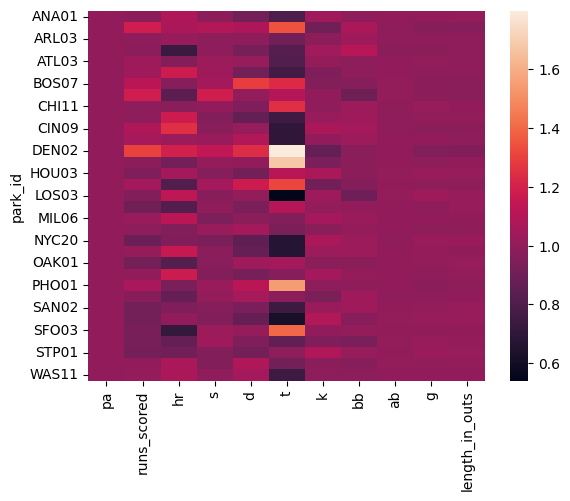

In [18]:
sns.heatmap(pfs)

# Now compute effects on scoring from component park factors

In [19]:
# Generate a league-average stat line (scaled to 1 PA)
event_freqs = home_game_totals[stats].sum()/home_game_totals['pa'].sum()
event_freqs

pa             1.000000
runs_scored    0.118928
hr             0.031286
s              0.143687
d              0.044496
t              0.004276
k              0.220692
bb             0.083593
ab             0.895208
dtype: float64

In [20]:
def compute_obp(stats):
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    obp = stats['ob']/stats['pa']
    return obp


In [21]:
def compute_ba(stats):
    stats['h'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']
    ba = stats['h']/stats['ab']
    return ba


In [22]:
def compute_base_runs(stats):
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']
    a = stats['h'] + stats['bb'] - stats['hr']
    b = (1.4 * stats['tb'] - .6 * stats['h'] - 3 * stats['hr'] + .1 * stats['bb']) * 1.02
    c = stats['ab'] - stats['h']
    d = stats['hr'] 
    return (a*b)/(b+c)+d


In [23]:
def compute_woba(stats):
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']

    woba = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return woba
                

In [24]:
# compare total runs to total BaseRuns
home_game_totals['runs_scored'].sum(), compute_base_runs(home_game_totals[stats].sum())

(160502, 158629.42685417825)

In [25]:
# league-total obp
compute_obp(event_freqs)

0.3073383482714469

In [26]:
# league-total woba
compute_woba(home_game_totals[stats].sum())

0.30590642190686207

In [27]:
# league-total woba -- should be the same
compute_woba(event_freqs)

0.30590642190686207

In [28]:
# This is the relative difference in PA/outs between two OBPs
# Outs/PA is 1-OBP, so it follows from there.
# Can call this with obp1 as adjusted OBP and obp2 as league/baseline OBP
def compute_pa_adj(obp1, obp2):
    return ((1-obp2)/(1-obp1))

In [29]:
compute_pa_adj(.350, .3)

1.0769230769230769

In [30]:
# Take the league-average line and adjust it by component PFs
def compute_adj_freqs(pfs):
    events = ['s', 'd', 't', 'hr', 'bb', 'ab']
    return pfs[events] * event_freqs[events]


In [31]:
compute_adj_freqs(pfs)

,s,d,t,hr,bb,ab
park_id,,,,,,
ANA01,0.141622,0.040614,0.003411,0.033955,0.083273,0.897361
ARL02,0.157060,0.048090,0.005753,0.033523,0.089370,0.888821
ARL03,0.142134,0.044369,0.003866,0.031849,0.086432,0.892445
ATL02,0.142653,0.041012,0.003519,0.023031,0.092727,0.882112
ATL03,0.148282,0.045200,0.003466,0.030028,0.082693,0.895163
BAL12,0.148666,0.040592,0.003266,0.036730,0.082627,0.896680
BOS07,0.151260,0.057441,0.005258,0.030172,0.080679,0.898735
BUF05,0.170656,0.044783,0.004691,0.026304,0.074535,0.901184
CHI11,0.143970,0.042013,0.005339,0.030597,0.086182,0.889757


In [32]:
# Compute the park-adjusted league-average lines
adj_freqs = compute_adj_freqs(pfs)
adj_freqs['pa'] = 1

# Compute a few stats on these adjusted lines
pfs['woba'] = compute_woba(adj_freqs)
pfs['bsr'] = compute_base_runs(adj_freqs)
pfs['obp'] = compute_obp(adj_freqs)
pfs['ba'] = compute_ba(adj_freqs)

# Compute pfs by comparing the adjusted lines to unadjusted
pfs['pf_pa_exp'] = compute_pa_adj(pfs['obp'], compute_obp(event_freqs))
pfs['pf_woba'] = pfs['woba']/compute_woba(event_freqs)
pfs['pf_bsr'] = pfs['bsr']/compute_base_runs(event_freqs)
pfs['pf_ba'] = pfs['ba']/compute_ba(event_freqs)

pfs['papg'] = 1/pfs['g']
pfs['papo'] = 1/pfs['length_in_outs']

pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
ANA01,1.0,0.985474,1.085297,0.985627,0.912767,0.797748,1.032689,0.996170,1.002405,0.998288,...,0.302996,0.115891,0.302875,0.244720,0.993598,0.990487,0.985960,0.979128,1.001714,0.992621
ARL02,1.0,1.180221,1.071480,1.093065,1.080777,1.345389,0.907081,1.069107,0.992866,0.965743,...,0.332693,0.136170,0.333795,0.275000,1.039712,1.087564,1.158490,1.100275,1.035472,1.035604
ARL03,1.0,0.994812,1.017988,0.989188,0.997156,0.904170,0.985053,1.033962,0.996914,0.993503,...,0.306858,0.118131,0.308650,0.249000,1.001897,1.003109,1.005021,0.996249,1.006539,1.002708
ATL02,1.0,0.984559,0.736148,0.992798,0.921715,0.822915,1.042677,1.109277,0.985371,0.984559,...,0.289644,0.104909,0.302943,0.238309,0.993694,0.946837,0.892536,0.953476,1.015683,1.002937
ATL03,1.0,1.035589,0.959772,1.031976,1.015836,0.810586,1.012332,0.989232,0.999950,1.003381,...,0.306324,0.117638,0.309669,0.253559,1.003376,1.001364,1.000827,1.014490,0.996630,1.005859
BAL12,1.0,1.041847,1.173997,1.034646,0.912257,0.763866,0.945611,0.988453,1.001645,0.989590,...,0.313827,0.123563,0.311881,0.255669,1.006602,1.025894,1.051237,1.022935,1.010519,1.005762
BOS07,1.0,1.116663,0.964399,1.052704,1.290940,1.229615,0.954302,0.965147,1.003940,0.987199,...,0.325714,0.131169,0.324811,0.271640,1.025879,1.064752,1.115943,1.086833,1.012967,1.023501
BUF05,1.0,1.183644,0.840745,1.187692,1.006449,1.097092,1.002175,0.891644,1.006675,0.978778,...,0.313988,0.122681,0.320969,0.273456,1.020074,1.026419,1.043728,1.094100,1.021682,1.025618
CHI11,1.0,0.988590,0.977979,1.001965,0.944192,1.248505,0.995835,1.030975,0.993911,1.012804,...,0.305252,0.117122,0.308100,0.249415,1.001101,0.997860,0.996433,0.997910,0.987358,1.000482


In [33]:
import plotly.express as px

In [34]:
# How does the composite BaseRuns-based pf do against runs/PA?
px.scatter(pfs.reset_index(), y='runs_scored', x='pf_bsr', trendline="ols", hover_name='park_id')

In [35]:
# How does the adjusted-OBP estimate of PA adjustment do against observed PA/out and PA/game?
px.scatter(pfs.reset_index(), y=['papo', 'papg'], x='pf_pa_exp', trendline="ols", hover_name='park_id')

In [36]:
pfs.sort_values(by='t')

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
LOS03,1.0,0.956927,1.132592,0.973072,1.007266,0.540734,1.041087,0.895036,1.010611,1.036222,...,0.301844,0.115945,0.297203,0.245808,0.985578,0.986721,0.986426,0.983479,0.965044,0.985999
SEA03,1.0,0.912842,1.000835,0.955659,0.870185,0.620194,1.095652,0.972125,1.003686,1.016319,...,0.289112,0.106626,0.291263,0.233721,0.977318,0.945100,0.907137,0.935120,0.983943,0.979605
NYC20,1.0,0.887015,0.950774,0.929119,0.853715,0.664293,1.073026,1.030036,0.995461,1.026350,...,0.285534,0.104010,0.290180,0.229005,0.975827,0.933402,0.884886,0.916249,0.974326,0.977825
NYC21,1.0,1.010083,1.159504,0.981825,0.868167,0.665640,1.030796,1.032094,0.998300,1.012069,...,0.305862,0.118057,0.305104,0.244861,0.996785,0.999855,1.004390,0.979690,0.988075,1.000489
CIN09,1.0,1.084523,1.249423,0.976976,1.016734,0.699068,1.070124,1.054715,0.997446,0.980887,...,0.320510,0.128183,0.315865,0.255004,1.012464,1.047738,1.090538,1.020273,1.019485,1.012939
CLE08,1.0,1.058133,1.030459,1.024504,1.094946,0.701535,1.001625,1.029295,0.998572,1.002404,...,0.315700,0.124049,0.317209,0.258597,1.014457,1.032015,1.055365,1.034650,0.997601,1.011263
SAN02,1.0,0.909846,0.944287,0.964388,0.933236,0.740707,1.026758,1.034015,0.999058,1.006325,...,0.294618,0.109454,0.299242,0.237941,0.988447,0.963099,0.931199,0.952004,0.993715,0.985314
WAS11,1.0,1.010868,1.075323,0.994780,1.051303,0.743443,0.989294,0.988032,1.002576,0.998000,...,0.310260,0.120765,0.309130,0.252406,1.002593,1.014230,1.027428,1.009878,1.002004,1.000401
CHI12,1.0,0.989454,1.172787,0.957035,0.869087,0.749484,1.020812,1.041697,0.994863,1.005186,...,0.304800,0.117673,0.303160,0.242622,0.994004,0.996382,1.001128,0.970734,0.994841,0.995933


In [37]:
pfs.T

park_id,ANA01,ARL02,ARL03,ATL02,ATL03,BAL12,BOS07,BUF05,CHI11,CHI12,...,PHI13,PHO01,PIT08,SAN02,SEA03,SFO03,STL10,STP01,TOR02,WAS11
pa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
runs_scored,0.985474,1.180221,0.994812,0.984559,1.035589,1.041847,1.116663,1.183644,0.988590,0.989454,...,1.001129,1.061615,0.971603,0.909846,0.912842,0.927497,0.920800,0.916059,1.000195,1.010868
hr,1.085297,1.071480,1.017988,0.736148,0.959772,1.173997,0.964399,0.840745,0.977979,1.172787,...,1.170259,0.930134,0.870956,0.944287,1.000835,0.715480,0.872972,0.902152,1.074969,1.075323
s,0.985627,1.093065,0.989188,0.992798,1.031976,1.034646,1.052704,1.187692,1.001965,0.957035,...,0.963228,1.026731,1.008709,0.964388,0.955659,1.031433,1.038653,0.955690,0.954230,0.994780
d,0.912767,1.080777,0.997156,0.921715,1.015836,0.912257,1.290940,1.006449,0.944192,0.869087,...,0.921064,1.116082,1.059284,0.933236,0.870185,1.010404,0.945579,0.914107,1.089392,1.051303
t,0.797748,1.345389,0.904170,0.822915,0.810586,0.763866,1.229615,1.097092,1.248505,0.749484,...,0.967802,1.547305,0.982909,0.740707,0.620194,1.395834,0.858457,0.988770,0.911099,0.743443
k,1.032689,0.907081,0.985053,1.042677,1.012332,0.945611,0.954302,1.002175,0.995835,1.020812,...,1.050990,0.988294,0.937243,1.026758,1.095652,1.001707,0.943833,1.087116,0.984491,0.989294
bb,0.996170,1.069107,1.033962,1.109277,0.989232,0.988453,0.965147,0.891644,1.030975,1.041697,...,1.008344,0.994911,1.039470,1.034015,0.972125,1.007342,0.933270,1.014327,0.966501,0.988032
ab,1.002405,0.992866,0.996914,0.985371,0.999950,1.001645,1.003940,1.006675,0.993911,0.994863,...,1.000087,1.000874,0.995569,0.999058,1.003686,0.998574,1.006511,0.998797,1.002942,1.002576
g,0.998288,0.965743,0.993503,0.984559,1.003381,0.989590,0.987199,0.978778,1.012804,1.005186,...,0.995632,0.982036,0.988996,1.006325,1.016319,1.000017,1.014315,1.024129,1.004775,0.998000
